In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
def generate_config(x0=0, y0=20, n=30, dx=1.):
    """Returns the initial configuration of the n chained particles, which is a horizontal line.
    The function returns an array, which has n elements, where each element is a tuple consisting
    of the x- and y-component of the respective particle. The x-coordinates are evenly spaced and
    the y-coordinates are set to some constant y0
    
    Parameters
    ----------
    x0 - x-coordinate of first particle. Standard value is 0.
    y0 - y-coordinate of all particles. Standard value is 20.
    n  - Number of particles, standard value is set to 30.
    dx - Horizontal spacing between neighbouring particles. Standard value is 1
    """
    
    r = np.zeros((n, 2))
    v = np.zeros((n, 2))
    r[:, 0] = np.linspace(x0, x0 + n*dx, n)
    r[:, 1] = np.linspace(y0, y0, n)
    
    return r, v

In [3]:
def potential_gradient(r, t, g=9.81 , k=20., f=0, amp=1, n_cycles=5):
    
    """Calculates the potential gradient for a given spatial configuration r of n particles in a chain.
    Returns a vector, where the i-th entry is a tuple consisting of the x- and y-coordinate of the gradient for particle i.
    Because the first and last particle are fixed, this function only computes the gradient for the second to the second-to-last particle,
    while for the first and last particle the gradient is always 0. Includes a sinusoidal force that acts upon the middle particle of the
    chain for a multiple of the driving oscillation period.
    
    Parameters
    ----------
    r - Array that has n-elements and each element has two scalar entries.
    g - Gravitational constant. Default value is 9.81.
    k - Spring constant. Default value is 20.
    f - Frequency of the driving force. Default is set to 0.
    amp - Amplitude of the driving force. Default is set to 1.
    """
    n = len(r)
    harmonic_gradient = np.zeros((n, 2))
    gravitational_gradient = np.zeros((n, 2))
    driving_force = amp * np.sin(f * t)
    
    harmonic_gradient[1:-1] = k * (r[1:-1] - r[:-2]) - k * (r[2:] - r[1:-1])
    gravitational_gradient[1:-1][:,1] = g
    total_gradient = harmonic_gradient + gravitational_gradient
    if f!=0 and t<n_cycles * 2*np.pi * 1/f:
        total_gradient[n//2,0] += driving_force
    
    return total_gradient
        

In [4]:
def vv(potential_gradient, r_init, v_init, dt=1/100, t_ges=100, g=9.81, k=50., f=0, amp=1):
    
    size = int(t_ges/dt)
    n = len(r_init)
    t = 0
    
    r_matrix, v_matrix = np.zeros((size, n, 2)), np.zeros((size, n, 2))
    r_matrix[0], v_matrix[0] = r_init, v_init
    
    for i in range(1,size):
        
        r = r_matrix[i-1]
        v = v_matrix[i-1]
        gradient = potential_gradient(r, t, g, k, f, amp)
        
        r_new = r + dt * v - 1/2 * dt**2 * gradient
        t += dt
        gradient_new = potential_gradient(r_new, t, g, k, f, amp) 
        v_new = v - 1/2 * dt * (gradient + gradient_new)
        
        v_new[:,1][r_new[:,1]<0]*=-1
        #Following line breaks energy conservation
        #r_new[:,1][r_new[:,1]<0]*=-1 
        
        r_matrix[i], v_matrix[i] = r_new, v_new

        
    return r_matrix, v_matrix

## 1st trial of velocity-verlet algorithm: n=30, g=9.81, k=50, no driving force

In [5]:
r_init, v_init = generate_config()
r_matrix, v_matrix = vv(potential_gradient, r_init, v_init)

<IPython.core.display.Javascript object>


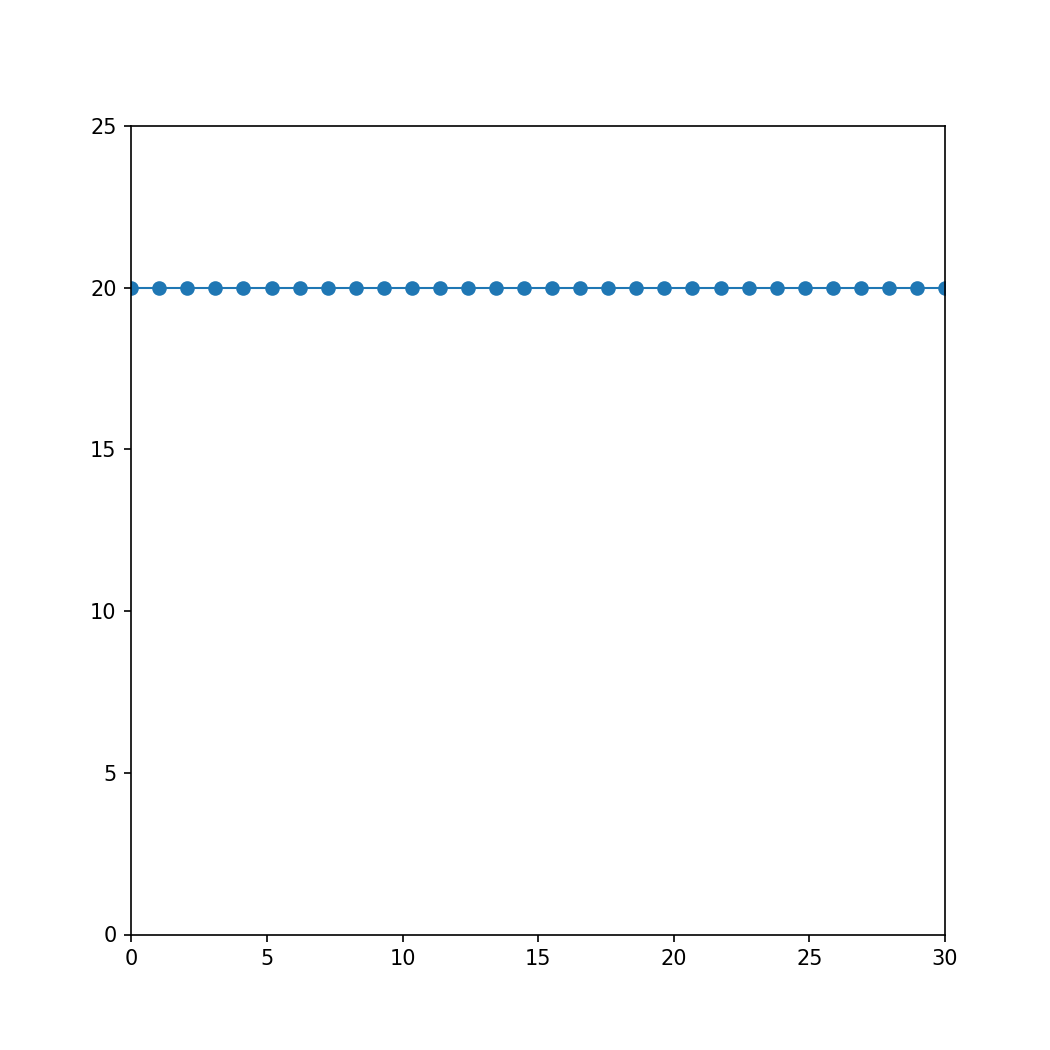

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
line, = ax.plot(r_matrix[0,:,0],r_matrix[0,:,1], '-o', lw = 1)
ax.set_xlim(( 0, np.max(r_matrix[0,:,0])))
ax.set_ylim((0, np.max(r_matrix[0,:,1]) + 5))

def animate(i):
    index = (10*i)%len(r_matrix)
    x, y = r_matrix[index,:,0], r_matrix[index,:,1]
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, interval=100, blit=True, repeat=False)
#HTML(anim.to_html5_video(embed_limit=40))

## 2nd trial of velocity-verlet algorithm: n=30, g=9.81, k=200, no driving force

In [7]:
r_init, v_init = generate_config()
r_matrix, v_matrix = vv(potential_gradient, r_init, v_init, k=200)

<IPython.core.display.Javascript object>


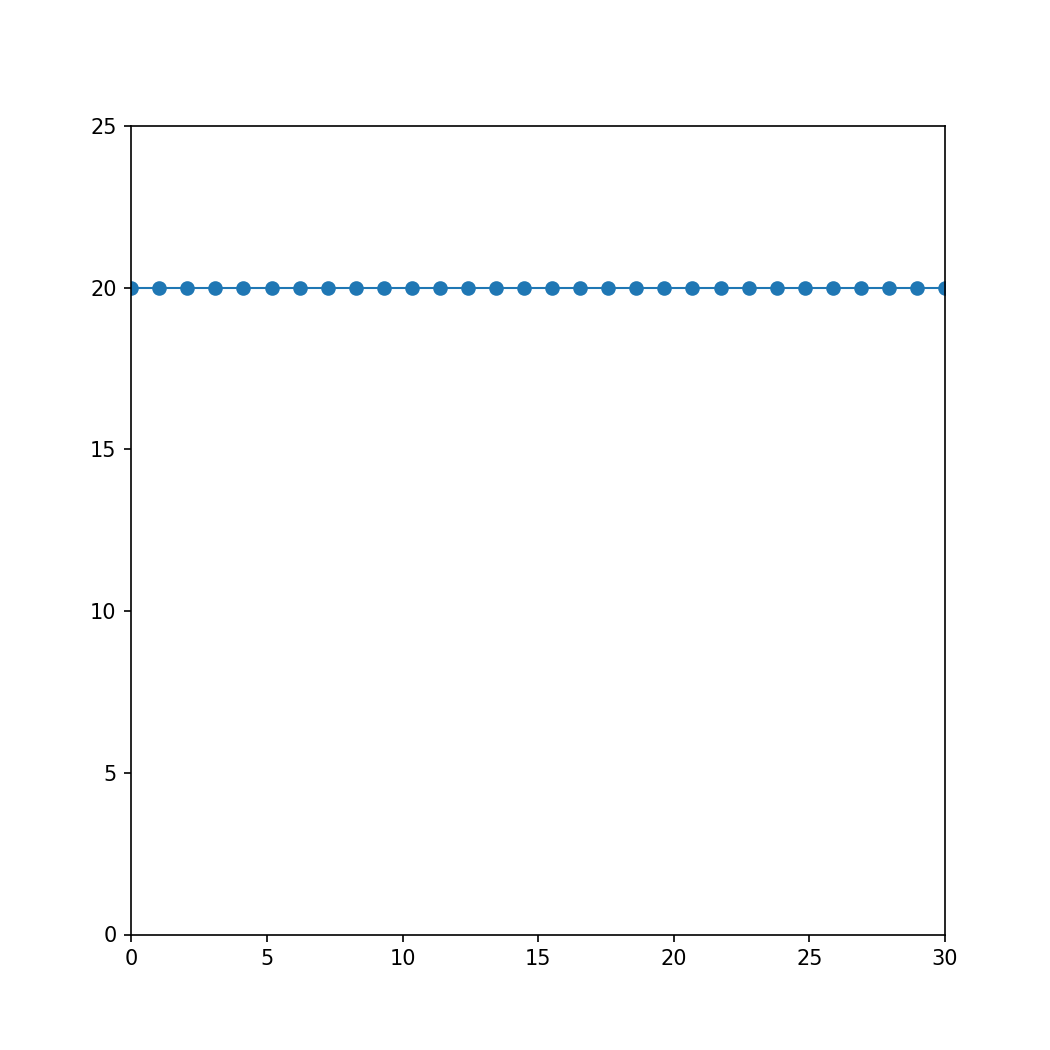

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
line, = ax.plot(r_matrix[0,:,0],r_matrix[0,:,1], '-o', lw=1)
ax.set_xlim(( 0, np.max(r_matrix[0,:,0])))
ax.set_ylim((0, np.max(r_matrix[0,:,1])+5))

anim = animation.FuncAnimation(fig, animate, interval=100, blit=True, repeat=False)

## 3rd trial of velocity-verlet algorithm: n=4, g=0, k=20, with sinusoidal driving force in x-direction

In [9]:
r_init, v_init = generate_config(n=4)
r_matrix1, v_matrix2 = vv(potential_gradient, r_init, v_init, k=20, g=0, amp=1, f=np.sqrt(20))
r_matrix2, v_matrix2 = vv(potential_gradient, r_init, v_init, k=20, g=0, amp=1, f=np.sqrt(3*20))

<IPython.core.display.Javascript object>


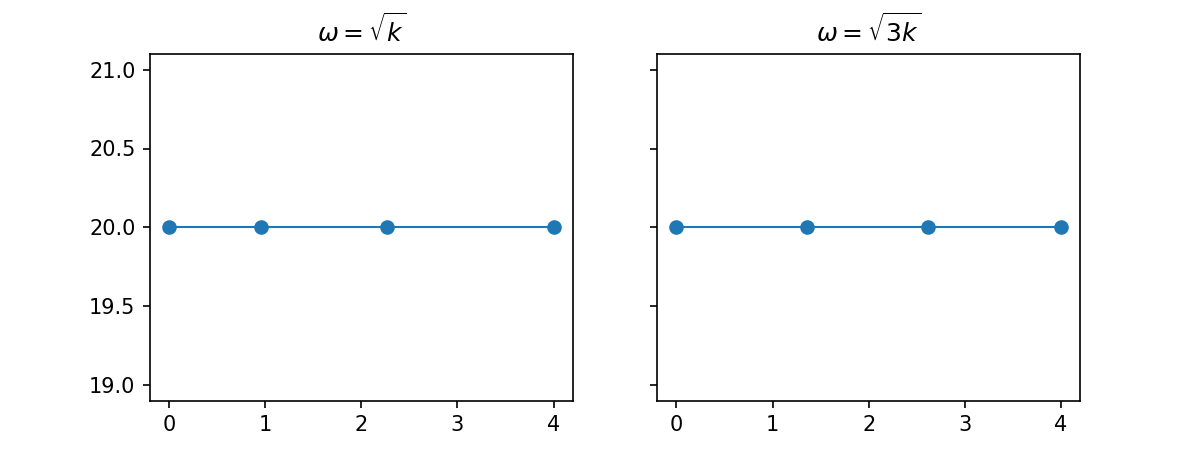

In [10]:
fig, ax = plt.subplots(1,2,figsize=(8, 3), sharey=True)
line1, = ax[0].plot(r_matrix1[0,:,0],r_matrix1[0,:,1], '-o', lw=1)
line2, = ax[1].plot(r_matrix1[0,:,0],r_matrix1[0,:,1], '-o', lw=1)

ax[0].set_title("$\omega = \sqrt{k}$")
ax[1].set_title("$\omega = \sqrt{3k}$")
def animate(i):
    index = (10*i)
    x1, y1 = r_matrix1[index,:,0], r_matrix1[index,:,1]
    x2, y2 = r_matrix2[index,:,0], r_matrix2[index,:,1]
    line1.set_data(x1,y1)
    line2.set_data(x2,y2)
    return line,
    
anim = animation.FuncAnimation(fig, animate, interval=100, blit=True, repeat=False)